In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from skipper import tiling
from astropy import coordinates
from skipper import observe, visualize

### Define COSMOS region

In [3]:
# \\ COSMOS region
center = coordinates.SkyCoord ("10h00m28.6s+02d12m21.0s")
size =  (1.4, 1.4)

edges = [ (center.ra.deg-size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg+size[0]/2.),
          (center.ra.deg-size[0]/2., center.dec.deg+size[0]/2.) ]
#cosmos_area = geometry.Polygon ( edges )

### Create object that generates COSMOS dithering pattern

In [4]:
frd = tiling.FocusedRandomDither (center, random_max=0.1, offset_radius=0.01, ndither=40)

In [5]:
#frd._make_grid ()
#poly_l, area_a, centers = frd.compute_coverage ( cosmos_area )
centers = frd.get_centers ()

Text(0, 0.5, 'Dec (deg)')

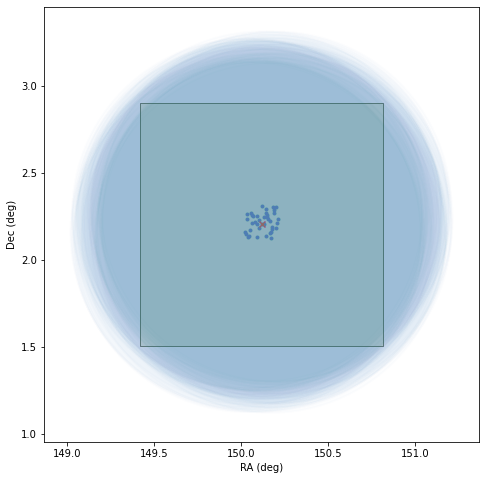

In [6]:
# \\ Visualize the dithering pattern
fig = plt.figure ( figsize=(8,8))
ax = plt.subplot(111, aspect='equal')
rect = patches.Rectangle ( [center.ra.deg - size[0]/2, center.dec.deg - size[1]/2],
                          width = size[0], 
                          height= size[1],
                         fc='lightgrey', ec='k', alpha=0.5)
ax.add_patch (rect)

for ij in range(frd.ndither):
    patch = patches.Circle ( centers[ij], radius=frd.fov_radius, fc='C0', ec='tab:blue', lw=2, alpha=0.01)
    ax.add_patch(patch)
    ax.scatter(*centers[ij], color='C0', marker='.')
ax.scatter ( *frd.center, color='r', marker='x')

ax.set_xlim ( center.ra.deg - 1.25,  center.ra.deg  + 1.25)
ax.set_ylim ( center.dec.deg- 1.25,  center.dec.deg + 1.25)

ax.set_xlabel ( 'RA (deg)')
ax.set_ylabel ('Dec (deg)')

### Build Observing Catalog and plan nights

In [296]:
# \\ Build observing catalog, and take a quick look
ocat = observe.ObsCatalog(comment='--', proposer='LeathaudGreene', 
                          propid='2020B-0288', seqid='Test Run')
catalog = ocat.build_catalog(centers[:,0], centers[:,1], 'COSMOS', 'N70', 'object', 10.*60)
assert not catalog.object.duplicated().any()

In [297]:
catalog

,comment,filter,seqtot,seqnum,seqid,expType,object,proposer,program,RA,propid,dec,expTime,count
0,--,N70,40,1,Test Run,object,COSMOS_J100028.60+021221.00_N70,LeathaudGreene,Merian,150.119167,2020B-0288,2.205833,600.0,1
1,--,N70,40,2,Test Run,object,COSMOS_J100025.25+021058.79_N70,LeathaudGreene,Merian,150.105212,2020B-0288,2.182998,600.0,1
2,--,N70,40,3,Test Run,object,COSMOS_J100008.52+021603.38_N70,LeathaudGreene,Merian,150.035529,2020B-0288,2.267606,600.0,1
3,--,N70,40,4,Test Run,object,COSMOS_J100013.75+021608.47_N70,LeathaudGreene,Merian,150.057312,2020B-0288,2.269020,600.0,1
4,--,N70,40,5,Test Run,object,COSMOS_J100032.31+021503.13_N70,LeathaudGreene,Merian,150.134630,2020B-0288,2.250871,600.0,1
5,--,N70,40,6,Test Run,object,COSMOS_J100037.41+021414.54_N70,LeathaudGreene,Merian,150.155901,2020B-0288,2.237373,600.0,1
6,--,N70,40,7,Test Run,object,COSMOS_J100029.61+021831.51_N70,LeathaudGreene,Merian,150.123414,2020B-0288,2.308753,600.0,1
7,--,N70,40,8,Test Run,object,COSMOS_J100050.54+021412.49_N70,LeathaudGreene,Merian,150.210596,2020B-0288,2.236805,600.0,1
8,--,N70,40,9,Test Run,object,COSMOS_J100006.30+020938.27_N70,LeathaudGreene,Merian,150.026267,2020B-0288,2.160633,600.0,1
9,--,N70,40,10,Test Run,object,COSMOS_J100024.74+021348.86_N70,LeathaudGreene,Merian,150.103093,2020B-0288,2.230240,600.0,1


In [304]:
g09 = pd.read_csv('../json/gama_85.csv', index_col=0)
g09['filter'] = 'N70'
g09['propid'] = '2020B-0288'
g09['object'] = ocat.build_object_names (g09)

In [305]:
g09

,comment,filter,seqtot,seqnum,seqid,expType,object,proposer,program,RA,propid,dec,expTime,count
0,--,N70,488,1,TEST,science,GAMA_J132337.89-005603.00_N70,LeathaudGreene,Merian,200.907909,2020B-0288,-0.934167,600.0,1
1,--,N70,488,2,TEST,science,GAMA_J132448.03-010036.00_N70,LeathaudGreene,Merian,201.200153,2020B-0288,-1.010001,600.0,1
2,--,N70,488,3,TEST,science,GAMA_J132558.78-010316.19_N70,LeathaudGreene,Merian,201.494921,2020B-0288,-1.054498,600.0,1
3,--,N70,488,4,TEST,science,GAMA_J132709.53-010555.59_N70,LeathaudGreene,Merian,201.789712,2020B-0288,-1.098778,600.0,1
4,--,N70,488,5,TEST,science,GAMA_J145638.24-004302.78_N70,LeathaudGreene,Merian,224.159362,2020B-0288,-0.717440,600.0,1
5,--,N70,488,6,TEST,science,GAMA_J145748.43-004624.05_N70,LeathaudGreene,Merian,224.451820,2020B-0288,-0.773348,600.0,1
6,--,N70,488,7,TEST,science,GAMA_J145859.20-004817.82_N70,LeathaudGreene,Merian,224.746704,2020B-0288,-0.804951,600.0,1
7,--,N70,488,8,TEST,science,GAMA_J150009.98-005010.21_N70,LeathaudGreene,Merian,225.041610,2020B-0288,-0.836171,600.0,1
8,--,N70,488,9,TEST,science,GAMA_J145014.96-004411.67_N70,LeathaudGreene,Merian,222.562348,2020B-0288,-0.736576,600.0,1
9,--,N70,488,10,TEST,science,GAMA_J145125.15-004739.08_N70,LeathaudGreene,Merian,222.854806,2020B-0288,-0.794189,600.0,1


In [306]:
mastercat = pd.concat([g09,catalog])
mastercat.index = np.arange(mastercat.index.size)
assert not mastercat.object.duplicated().any()

In [308]:
# \\ We need to deprioritize early targets in order to preserve them for the end of the run
obs_start, twibeg = ctio.get_sunriseset ( 2021, 3, 17 )
obs_end = obs_start + 0.5*(twibeg-obs_start)

obsframe = ctio.define_obsframe ( obs_start=obs_start, obs_end=obs_end )
alt_l = [ ctio.get_altitude(cc, obsframe) for cc in ocat.as_skycoord(mastercat)] 


#airmass = np.array([ai.secz[1] for ai in alt_l])
#print (f'Deprioritizing N={airmass[(airmass>0)&(airmass<1.6)].shape[0]} targets')
#mastercat.loc[(airmass>0)&(airmass<1.6)&(mastercat['object']!='COSMOS'), 'object'] = 'hour2_G09'

airmass = np.array([ai.secz[0] for ai in alt_l])
print (f'Deprioritizing N={airmass[(airmass>0)&(airmass<1.6)].shape[0]} targets')
mastercat.loc[(airmass>0)&(airmass<1.41)&(mastercat['object']!='COSMOS'), 'object'] = 'earlyGAMA'

2021-03-18 04:00:00
Deprioritizing N=82 targets


In [309]:
# \\ Define the observatory site -- default is CTIO
ctio = observe.ObservingSite ()
priorities = {'COSMOS':0, 'GAMA':1, 'earlyGAMA':2}

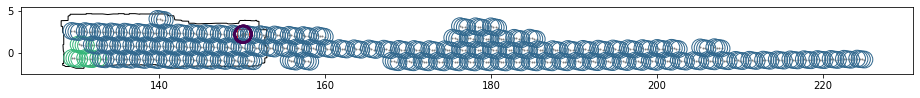

In [311]:
tq = mastercat
fov_radius = (3.18/np.pi)**0.5
plt.figure(figsize=(16,16))
ax = plt.subplot(111, aspect='equal')
patch1 = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=1)
ax.add_patch(patch1)

cosmos = patches.Rectangle ( ((center.ra - size[0]/2.*u.deg).value, 
                              (center.dec - size[1]/2.*u.deg).value),
                             *size, fc='None', ec='tab:red')
ax.add_patch(cosmos)

for name,row in tq.iterrows():
    cc = priorities[row['object'].split('_')[0]]/3.
    patch = patches.Circle ( (row.RA, row.dec), fov_radius, ec=plt.cm.viridis(cc), 
                            fc='None')
    
    ax.add_patch(patch)
        
ax.scatter(tq.RA, tq.dec, s=1, color='grey')

In [312]:
fmt = '%Y/%m/%d %I:%M %p'

In [313]:
nights = np.arange(5,18,1)
nights = np.concatenate([nights[:7], nights[8:]])
nights

array([ 5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17])

In [315]:
obs_start, twibeg = ctio.get_sunriseset ( 2021, 3, nights[0] )
obs_end = obs_start + 0.5*(twibeg-obs_start)

print(obs_start.astimezone(ctio.timezone).strftime(fmt))
print(obs_end.astimezone(ctio.timezone).strftime(fmt))

is_queued = ocat.plan_night ( obs_start, ctio, catalog=mastercat, obs_end=obs_end,
                             maxairmass=1.6, object_priority=priorities )

for night in nights[1:]:
    obs_start, twibeg = ctio.get_sunriseset ( 2021, 3, night)
    obs_end = obs_start + 0.5*(twibeg-obs_start)

    print(obs_start.astimezone(ctio.timezone).strftime(fmt))
    print(obs_end.astimezone(ctio.timezone).strftime(fmt))

    is_queued = ocat.plan_night ( obs_start, ctio, catalog=mastercat, obs_end=obs_end,
                                 maxairmass=1.6, is_queued=is_queued )

2021/03/05 09:00 PM
2021/03/06 01:57 AM
2021-03-06 04:00:00
==> 20210306_00, 3600.000000000005s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects


/Users/kadofong/env3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


==> 20210306_01, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
==> 20210306_02, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
==> 20210306_03, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
(180s) Not enough time for an exposure. Skipping...
2021/03/06 08:54 PM
2021/03/07 01:54 AM
2021-03-07 04:00:00
(360s) Not enough time for an exposure. Skipping...
==> 20210307_00, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
==> 20210307_01, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
==> 20210307_02, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 obje

==> 20210317_03, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
(540s) Not enough time for an exposure. Skipping...
2021/03/17 08:42 PM
2021/03/18 01:51 AM
2021-03-18 04:00:00
==> 20210317_23, 1079.9999999999898s available
0.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
Nothing to queue!!
==> 20210318_00, 3600.0s available
0.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
Nothing to queue!!
==> 20210318_01, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
==> 20210318_02, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=2.0 objects
==> 20210318_03, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s

Text(0, 0.5, 'N')

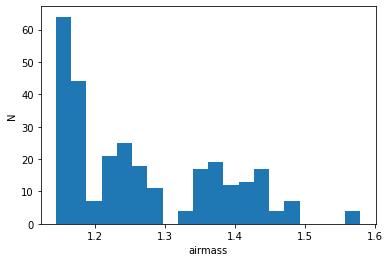

In [316]:
plt.hist(is_queued['airmass'].astype(float), bins=20)
plt.xlabel('airmass')
plt.ylabel('N')

In [317]:
assert is_queued.query('has_priority==0.')['is_queued'].all()

# Visualize queued pointings

In [318]:
from shapely import geometry
from descartes.patch import PolygonPatch
from astropy import units as u

In [319]:
g09edges = np.loadtxt('../data/g09edge.dat')
poly_g09 = geometry.Polygon(g09edges)  
print('The GAMA09 field area is: ' + str(poly_g09.area))
print('Fraction of the entire Merian Survey is: '+str(100*poly_g09.area/800))

The GAMA09 field area is: 140.6957220611181
Fraction of the entire Merian Survey is: 17.58696525763976


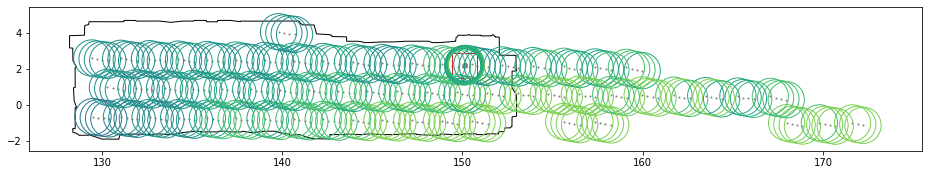

In [320]:
tq = mastercat.loc[is_queued.is_queued]
fov_radius = (3.18/np.pi)**0.5
plt.figure(figsize=(16,16))
ax = plt.subplot(111, aspect='equal')
patch1 = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=1)
ax.add_patch(patch1)

cosmos = patches.Rectangle ( ((center.ra - size[0]/2.*u.deg).value, 
                              (center.dec - size[1]/2.*u.deg).value),
                             *size, fc='None', ec='tab:red')
ax.add_patch(cosmos)

for name,row in tq.iterrows():
    timestamp = datetime.datetime.strptime (is_queued.loc[name,'qstamp'], '%Y%m%d_%H')
    if timestamp.hour>12:
        hr = timestamp.hour - 24.
    else:
        hr = timestamp.hour
    patch = patches.Circle ( (row.RA, row.dec), fov_radius, ec=plt.cm.viridis((hr+5)/10.), 
                            fc='None')
    
    ax.add_patch(patch)
        
ax.scatter(tq.RA, tq.dec, s=1, color='grey')

In [ ]:
tq = mastercat.loc[is_queued.is_queued]
fov_radius = (3.18/np.pi)**0.5
plt.figure(figsize=(16,4))
ax = plt.subplot(111, aspect='equal')
patch1 = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=1)
ax.add_patch(patch1)

cosmos = patches.Rectangle ( ((center.ra - size[0]/2.*u.deg).value, 
                              (center.dec - size[1]/2.*u.deg).value),
                             *size, fc='None', ec='tab:red')
ax.add_patch(cosmos)

ax.scatter(tq.RA, tq.dec, s=1, color='grey')

frame=0
for name,qrow in is_queued.loc[is_queued.is_queued].sort_values('qstamp').iterrows():
    row = tq.loc[name]
    timestamp = datetime.datetime.strptime (is_queued.loc[name,'qstamp'], '%Y%m%d_%H')

    if timestamp.day > (night+1):
        continue
    if timestamp.hour>12:
        hr = timestamp.hour - 24.
    else:
        hr = timestamp.hour
    patch = patches.Circle ( (row.RA, row.dec), fov_radius, ec=plt.cm.viridis((hr+5)/10.), 
                            fc='None')

    ax.add_patch(patch)
    plt.tight_layout ()
    plt.savefig(f'../../figures/anim/{frame:05d}.png')
    frame+=1

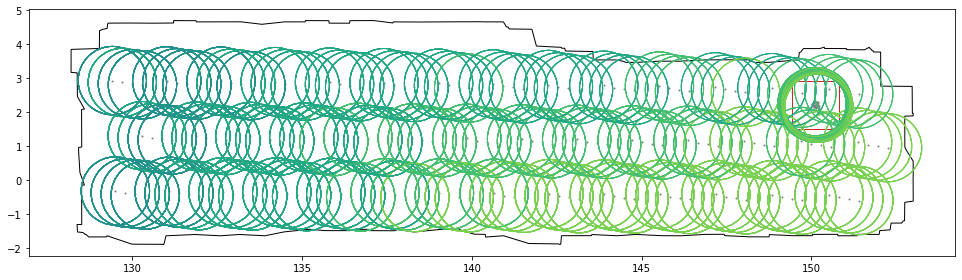

In [89]:
tq = mastercat.loc[is_queued.is_queued]
fov_radius = (3.18/np.pi)**0.5
plt.figure(figsize=(16,4))
ax = plt.subplot(111, aspect='equal')
patch1 = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=1)
ax.add_patch(patch1)

cosmos = patches.Rectangle ( ((center.ra - size[0]/2.*u.deg).value, 
                              (center.dec - size[1]/2.*u.deg).value),
                             *size, fc='None', ec='tab:red')
ax.add_patch(cosmos)

ax.scatter(tq.RA, tq.dec, s=1, color='grey')

for night in nights:
    for name,row in tq.iterrows():
        timestamp = datetime.datetime.strptime (is_queued.loc[name,'qstamp'], '%Y%m%d_%H')

        if timestamp.day > (night+1):
            continue
        if timestamp.hour>12:
            hr = timestamp.hour - 24.
        else:
            hr = timestamp.hour
        patch = patches.Circle ( (row.RA, row.dec), fov_radius, ec=plt.cm.viridis((hr+5)/10.), 
                                fc='None')

        ax.add_patch(patch)
    plt.tight_layout ()
    plt.savefig(f'../../figures/anim/night{int(night):02d}.png')
